<a href="https://colab.research.google.com/github/Vikrampaswan07/Image-sketch_using_GAN/blob/main/Image-to-sketch_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!rm -rf Image-to-Sketch-using-Cycle-GAN
! git clone https://github.com/Harshpatel44/Image-to-Sketch-using-Cycle-GAN.git
%cd Image-to-Sketch-using-Cycle-GAN

/content
Cloning into 'Image-to-Sketch-using-Cycle-GAN'...
remote: Enumerating objects: 723, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 723 (delta 4), reused 0 (delta 0), pack-reused 714
Receiving objects: 100% (723/723), 245.82 MiB | 35.06 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Image-to-Sketch-using-Cycle-GAN



## Load and Visualize the Data

In [ ]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

In [ ]:
def get_data_loader(image_type, image_dir='sketch2face', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size,128)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='face',batch_size=25)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='sketch',batch_size=25)

## Display some Training Images


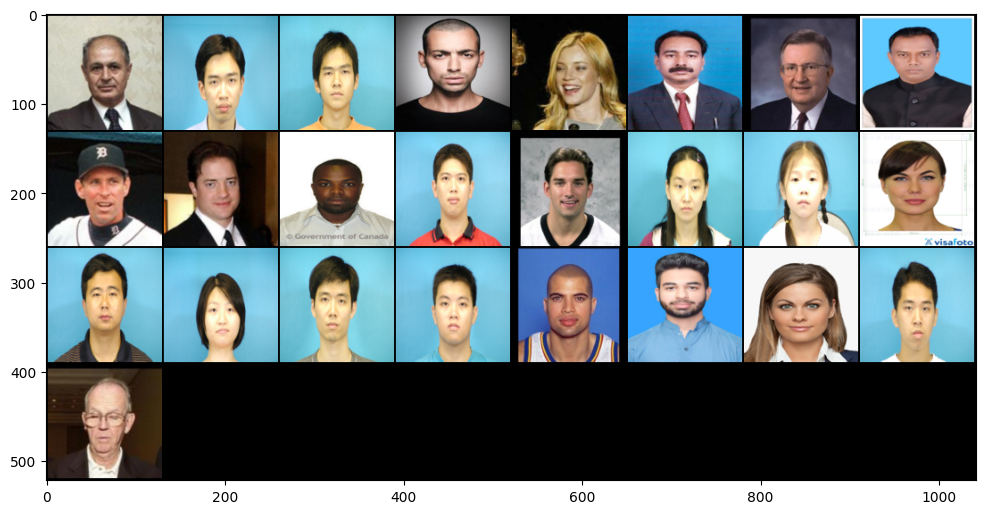

In [ ]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

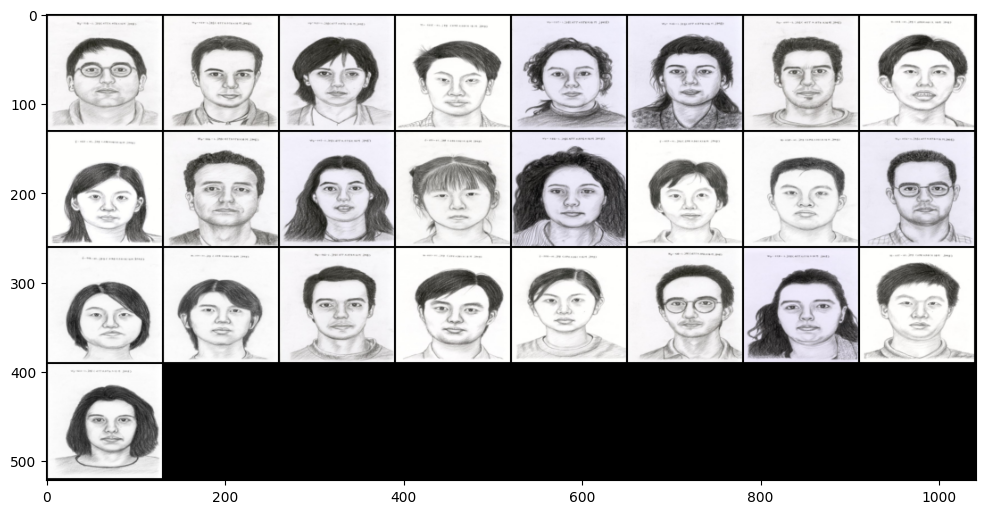

In [ ]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [ ]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.1176)
Max:  tensor(1.)


In [ ]:
# helper scale function
def scale(x, feature_range=(-1, 1)):    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.7647)
Scaled max:  tensor(1.)


---
## Define the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator


In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

Residual Block

In [ ]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

In [ ]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## The Generator 

In [ ]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
Network

In [ ]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

# pretrained weights will be used for further training and evaluating the model.
D_X.load_state_dict(torch.load('weights/D_X.pth'))
G_XtoY.load_state_dict(torch.load('weights/G_XtoY.pth'))
D_Y.load_state_dict(torch.load('weights/D_Y.pth'))
G_YtoX.load_state_dict(torch.load('weights/G_YtoX.pth'))

Models moved to GPU.


<All keys matched successfully>

---
### Loss Functions



In [ ]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Optimizers


In [ ]:
import torch.optim as optim

# hyperparams for Adam optimizer
#lr=0.0002
lr=0.00000001
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# function to save weights

In [ ]:
def save_weights():
    torch.save(D_X.state_dict(),'weights/D_X.pth')
    torch.save(G_XtoY.state_dict(),'weights/G_XtoY.pth')
    torch.save(D_Y.state_dict(),'weights/D_Y.pth')
    torch.save(G_YtoX.state_dict(),'weights/G_YtoX.pth')    

---

## Training a CycleGAN

In [ ]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse
import imageio

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    
    
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #fixed_Y is test_images for G1
    #fixed_X is test_images for G2
    
    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path,merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path,merged)
    print('Saved {}'.format(path))
    

In [ ]:
# import save code
from helpers import save_samples, checkpoint

In [ ]:
# train the network
import matplotlib.pyplot as plt
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    img=plt.imread('/content/WhatsApp Image 2023-05-09 at 17.25.22.jpeg')
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    for batch in test_dataloader_X:
      fixed_X = batch[0]
      break
    for batch in test_dataloader_Y:
      fixed_Y = batch[0]
      break
    #fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        # Train with real images
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images  
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images
        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=5)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=5)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            
            #to_tensor = transforms.ToTensor()
            #tensor = to_tensor(img)
            #plt.imshow(0.5*G_XtoY(img)[0][0]+0.5)
            #plt.show()

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=25)
            G_YtoX.train()
            G_XtoY.train()
            save_weights()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=10006
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [ ]:
n_epochs = 400
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs)

Epoch [   10/  400] | d_X_loss: 0.0518 | d_Y_loss: 0.0212 | g_total_loss: 2.3012
Epoch [   20/  400] | d_X_loss: 0.0873 | d_Y_loss: 0.0253 | g_total_loss: 2.1705
Epoch [   30/  400] | d_X_loss: 0.0599 | d_Y_loss: 0.0488 | g_total_loss: 1.9878
Epoch [   40/  400] | d_X_loss: 0.0961 | d_Y_loss: 0.0442 | g_total_loss: 1.9681
Epoch [   50/  400] | d_X_loss: 0.0545 | d_Y_loss: 0.0337 | g_total_loss: 2.0913
Epoch [   60/  400] | d_X_loss: 0.0848 | d_Y_loss: 0.0270 | g_total_loss: 2.1442
Epoch [   70/  400] | d_X_loss: 0.0812 | d_Y_loss: 0.0361 | g_total_loss: 2.1630
Epoch [   80/  400] | d_X_loss: 0.2425 | d_Y_loss: 0.0539 | g_total_loss: 2.0738
Epoch [   90/  400] | d_X_loss: 0.0491 | d_Y_loss: 0.0497 | g_total_loss: 2.0932


Epoch [  100/  400] | d_X_loss: 0.0971 | d_Y_loss: 0.0445 | g_total_loss: 2.0420


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/  400] | d_X_loss: 0.0508 | d_Y_loss: 0.0330 | g_total_loss: 2.1667
Epoch [  120/  400] | d_X_loss: 0.0737 | d_Y_loss: 0.0322 | g_total_loss: 2.0579
Epoch [  130/  400] | d_X_loss: 0.0449 | d_Y_loss: 0.0348 | g_total_loss: 2.1926
Epoch [  140/  400] | d_X_loss: 0.1150 | d_Y_loss: 0.0186 | g_total_loss: 2.2402
Epoch [  150/  400] | d_X_loss: 0.0945 | d_Y_loss: 0.0318 | g_total_loss: 2.0594
Epoch [  160/  400] | d_X_loss: 0.0876 | d_Y_loss: 0.0283 | g_total_loss: 2.1130
Epoch [  170/  400] | d_X_loss: 0.0897 | d_Y_loss: 0.0311 | g_total_loss: 2.1434
Epoch [  180/  400] | d_X_loss: 0.0650 | d_Y_loss: 0.0315 | g_total_loss: 2.1115
Epoch [  190/  400] | d_X_loss: 0.1601 | d_Y_loss: 0.0350 | g_total_loss: 2.0599


Epoch [  200/  400] | d_X_loss: 0.1163 | d_Y_loss: 0.0346 | g_total_loss: 2.0047


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/  400] | d_X_loss: 0.0558 | d_Y_loss: 0.0401 | g_total_loss: 2.0704
Epoch [  220/  400] | d_X_loss: 0.0648 | d_Y_loss: 0.0242 | g_total_loss: 2.1122
Epoch [  230/  400] | d_X_loss: 0.0645 | d_Y_loss: 0.0275 | g_total_loss: 2.1677
Epoch [  240/  400] | d_X_loss: 0.0725 | d_Y_loss: 0.0414 | g_total_loss: 2.0762
Epoch [  250/  400] | d_X_loss: 0.0489 | d_Y_loss: 0.0289 | g_total_loss: 2.4172
Epoch [  260/  400] | d_X_loss: 0.0855 | d_Y_loss: 0.0231 | g_total_loss: 2.3868
Epoch [  270/  400] | d_X_loss: 0.0629 | d_Y_loss: 0.0423 | g_total_loss: 2.0455
Epoch [  280/  400] | d_X_loss: 0.0608 | d_Y_loss: 0.0417 | g_total_loss: 2.0875
Epoch [  290/  400] | d_X_loss: 0.0481 | d_Y_loss: 0.0305 | g_total_loss: 2.1449


Epoch [  300/  400] | d_X_loss: 0.0587 | d_Y_loss: 0.0334 | g_total_loss: 2.1451


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/  400] | d_X_loss: 0.0993 | d_Y_loss: 0.0428 | g_total_loss: 2.1587
Epoch [  320/  400] | d_X_loss: 0.0749 | d_Y_loss: 0.0449 | g_total_loss: 2.0112
Epoch [  330/  400] | d_X_loss: 0.1340 | d_Y_loss: 0.0309 | g_total_loss: 2.0132
Epoch [  340/  400] | d_X_loss: 0.0596 | d_Y_loss: 0.0386 | g_total_loss: 2.0404
Epoch [  350/  400] | d_X_loss: 0.1461 | d_Y_loss: 0.0361 | g_total_loss: 2.2076
Epoch [  360/  400] | d_X_loss: 0.0526 | d_Y_loss: 0.0258 | g_total_loss: 2.2565
Epoch [  370/  400] | d_X_loss: 0.0697 | d_Y_loss: 0.0316 | g_total_loss: 1.9938
Epoch [  380/  400] | d_X_loss: 0.0563 | d_Y_loss: 0.0361 | g_total_loss: 2.1068
Epoch [  390/  400] | d_X_loss: 0.0623 | d_Y_loss: 0.0235 | g_total_loss: 2.1359


Epoch [  400/  400] | d_X_loss: 0.0935 | d_Y_loss: 0.0426 | g_total_loss: 2.1232


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png


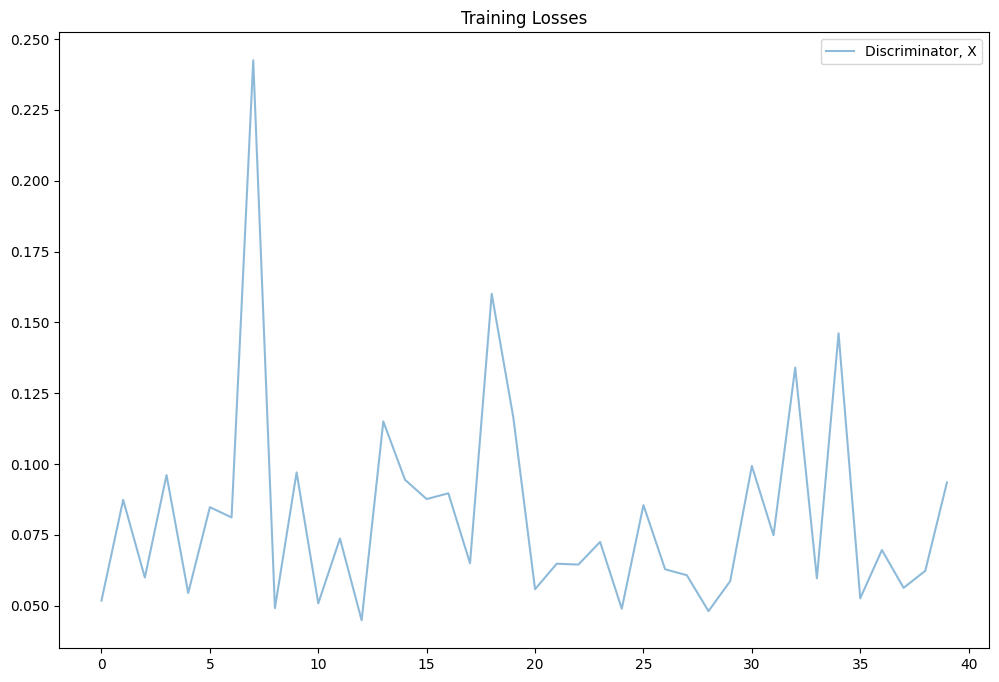

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)

plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!


In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


In [ ]:
torch.save(G_XtoY, 'pikram.pth')
input_data =plt.imread('/content/WhatsApp Image 2023-05-09 at 17.25.22.jpeg') 

# Load the saved model
G = torch.load('pikram.pth')

# Set the model to evaluation mode
G.eval()


# create a transform to convert the image to a tensor
to_tensor = transforms.ToTensor()

# apply the transform to the image
tensor = to_tensor(input_data).to(torch.device('cuda'))

# add a batch dimension to the tensor
tensor = tensor.unsqueeze(0)

# apply the generator model to the tensor
output_data = G(tensor)

# remove the batch dimension from the output tensor
output_data = output_data.squeeze(0)

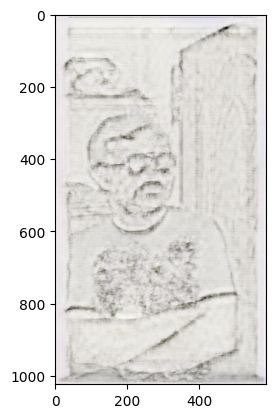

In [ ]:
output_array = output_data.cpu().detach().numpy()
output_array = output_array.transpose((1, 2, 0)) # swap dimensions to (height, width, color channels)
plt.imshow(output_array)

